# Brain MRI Segmentation using UNet architecture
MRI is a medical imaging technique that uses a strong magnetic field and radio waves
to create detailed images of the inside of the body.The manual segmentation and analysis of MRI is a difficult and time-consuming task and hence
can only be performed by expert neuroradiologists. An automatic and robust brain tumor segmentation will have a significant impact on brain tumor diagnosis and treatment.

## Importing necessary Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import F1Score

import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



## Specifying data paths
The used dataset was an LGG Segmentation Dataset. It comprises of MRI Images of brain with manuaglly segmented masks.

In [4]:
img_width = 256
img_height = 256

images_train = []

# print(mask_files)
data_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

In [5]:
mask_files = glob(pathname= data_path+'/*/*_mask*')
mask_files[:1]

['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif']

### Preparing Training Images
Here we seperate masks and mri images

In [6]:
for i in mask_files:
  images_train.append(i.replace('_mask', ''))
print(images_train[:5])


['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif']


In [7]:
len(images_train)

3929

There are all together 3929 Images from the 110 patients

## Data Visualization


Here are the few samples of the data



In [8]:
def plot_from_path(rows, columns, img_list_path, mask_list_path):
  fig = plt.figure( figsize = (12,12))
  for i in range(1, rows*columns+1):
    fig.add_subplot(rows,columns, i)
    img_path = img_list_path[i]
    mask_path = mask_list_path[i]
    image = cv2.imread(img_path)
    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    plt.imshow(image)
    plt.imshow(mask, alpha = 0.05)
  plt.show()

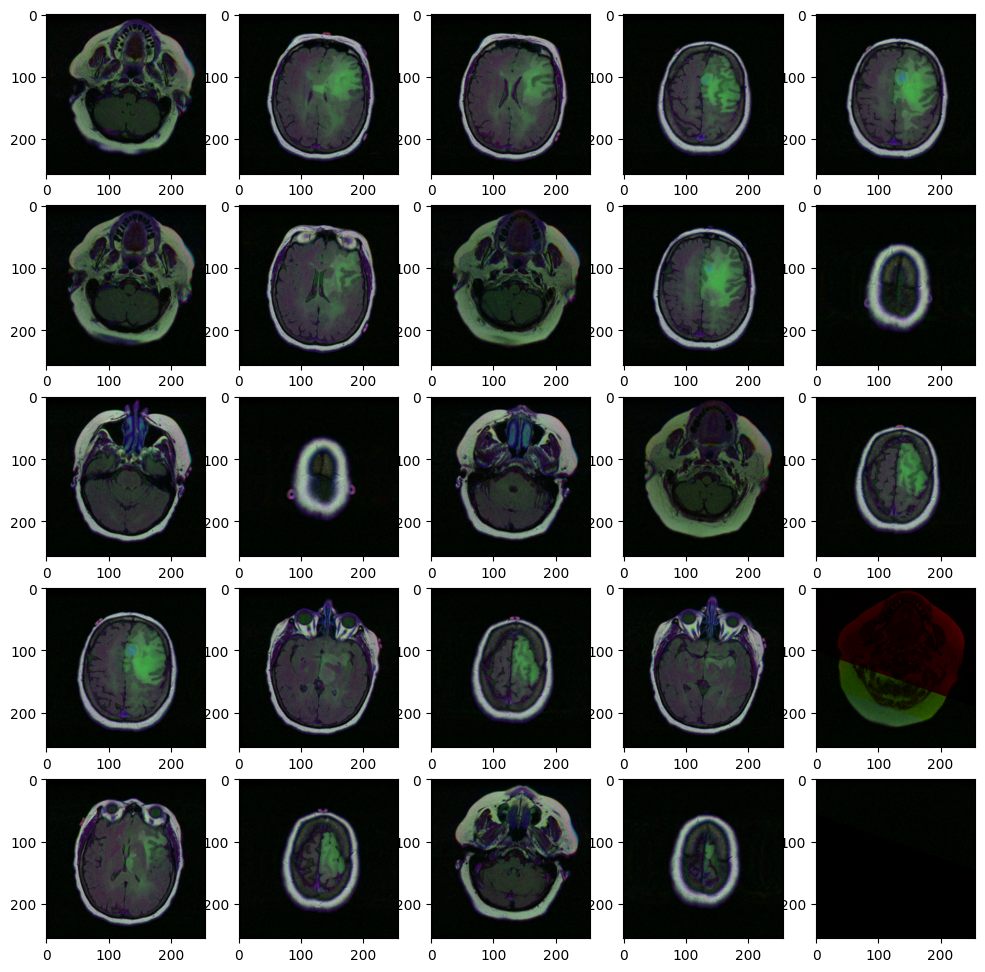

In [9]:
plot_from_path(5,5, images_train, mask_files)

## Data Preprocessing

### Splitting into test, train and validation


We split the data into train, test and validation datas alloting them 85%, 10% and 5% datas respectively

In [10]:
df = pd.DataFrame( data = {
    'images_train': images_train,
    'masks': mask_files
})
df_train, df_test = train_test_split(df, test_size = 0.10)
df_train, df_valid = train_test_split(df_train, test_size=0.05)

print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(3359, 2)
(393, 2)
(177, 2)


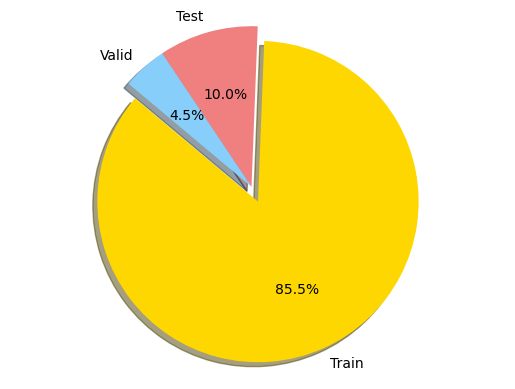

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
train_size = 3359   # sub with df_train.shape
test_size = 393# sub with df_test.shape
valid_size = 177 # sub with df_valid.shape

# Data to plot
sizes = [train_size, test_size, valid_size]
labels = ['Train', 'Test', 'Valid']
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice

# Plotting the pie chart
plt.pie(sizes,explode=explode,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()
plt.savefig('Pie Chart Train Test Valid.png')

### Generators, Augmentation, Normalization and Loss Calculator

In [11]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):

    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)


    for (img, mask) in train_gen:
        img, mask = normalize_data(img, mask)
        yield (img, mask)

In [12]:
def normalize_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [13]:
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

#### IoU and Dice Coefficient

**IoU**

<img src="IoU.png" alt="IoU" />

**Dice Coefficient**

<img src="Dice Coefficient.png" alt="dice coefficient" />

## Defining encoder and decoder block

In [14]:
def encoder_block(inputs, filters):
    conv = Conv2D(filters, kernel_size = (3,3), padding="same")(inputs)
    bn = Activation("relu")(conv)
    conv = Conv2D(filters, kernel_size = (3,3), padding="same")(bn)
    bn = BatchNormalization(axis=3)(conv)
    bn = Activation("relu")(bn)
    pool = MaxPooling2D(pool_size=(2, 2))(bn)

    return conv, pool;

def decoder_block(inputs, conv, num_filters):
  conv_trans = Conv2DTranspose(num_filters, kernel_size= (2,2), strides = (2,2), padding = "same")(inputs)

  x = concatenate([conv_trans, conv], axis = 3)
  x = Conv2D(num_filters, kernel_size = (3,3), padding= "same")(x)
  x = Activation("relu")(x)
  x = Conv2D(num_filters, kernel_size = (3,3), padding = "same")(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)

  return x ;





## Defining the U-Net Architecture

In [15]:
def unet_model(input_shape = (img_width, img_height, 3)):
  inputs = Input(input_shape)

  #Contracting paths ( Encoder Path) / Downsampling

  conv1, pool1 = encoder_block( inputs, 64)
  conv2, pool2 = encoder_block(pool1, 128)
  conv3, pool3 = encoder_block(pool2, 256)
  conv4, pool4 = encoder_block(pool3, 512)


  # Bottleneck
  b1 = Conv2D(filters = 1024, kernel_size = (3,3), padding = 'same')(pool4)
  b1 = Activation('relu')(b1)
  b1 = Conv2D(filters = 1024, kernel_size = (3,3), padding = 'same')(b1)
  b1 = BatchNormalization(axis = 3)(b1)
  b1 = Activation('relu')(b1)

  #Expansive path ( Decoder path) / UpSampling

  s5 = decoder_block(b1, conv4, 512)
  s6 = decoder_block(s5, conv3, 256)
  s7 = decoder_block(s6, conv2, 128)
  s8 = decoder_block(s7, conv1 , 64)


  #Output
  outputs = Conv2D(filters = 1, kernel_size = (1,1), activation = "sigmoid")(s8)

  return Model(inputs=[inputs], outputs = [outputs])

<img src='unet_arch.png' alt='Unet architecture'>

## Training parameters and augmentation dictionary

In [16]:
epochs = 75
batch_size = 32
lr = 1e-4

train_generator_args = dict(
    rotation_range = 0.25,
    width_shift_range = 0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen  = train_generator( df_train, batch_size, train_generator_args)
test_gen = train_generator(df_test, batch_size, dict() )


model = unet_model(input_shape =(256,256, 3))
optimizer = Adam(lr = lr , beta_1 = 0.9, beta_2 = 0.999, epsilon = None, amsgrad = False)


model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])
callbacks = [
    ModelCheckpoint('unet_model.hdf5',verbose=1, save_best_only=True )
]

history = model.fit(
      train_gen,
      steps_per_epoch = len(df_train) / batch_size,
      epochs = epochs,
      callbacks = callbacks,
      validation_data = test_gen,
      validation_steps = len(df_valid) / batch_size
)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 3359 validated image filenames.
Found 3359 validated image filenames.
Epoch 1/75
105/104 [==============================] - ETA: 0s - loss: -0.1583 - binary_accuracy: 0.9509 - iou: 0.0881 - dice_coefficients: 0.1584Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02253, saving model to unet_model.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 243s 2s/step - loss: -0.1583 - binary_accuracy: 0.9509 - iou: 0.0881 - dice_coefficients: 0.1584 - val_loss: -0.0225 - val_binary_accuracy: 0.9894 - val_iou: 0.0115 - val_dice_coefficients: 0.0225
Epoch 2/75
105/104 [==============================] - ETA: 0s - loss: -0.2712 - binary_accuracy: 0.9892 - iou: 0.1595 - dice_coefficients: 0.2712
Epoch 2: val_loss did not improve from -0.02253
104/104 [==============================] - 165s 2s/step - loss: -0.2712 - binary_accuracy: 0.9892 - iou: 0.1595 - dice_coefficients: 0.2712 - val_loss: -0.0178 - val_binary_accuracy: 0.9906 - val_iou: 0.0090 - val_dice_coefficients: 0.0171
Epoch 3/75
105/104 [==============================] - ETA: 0s - loss: -0.3422 - binary_accuracy: 0.9916 - iou: 0.2102 - dice_coefficients: 0.3421
Epoch 3: val_loss improved from -0.02253 to -0.04344, saving model to unet_model.hdf5
104/104 [==============================] - 172s 2s/step - loss: -0.3422 - binary_accuracy: 0.9

In [6]:
# keras.utils.plot_model(model, to_file = "Model.png", show_shapes=True)


## Plotting the metrics

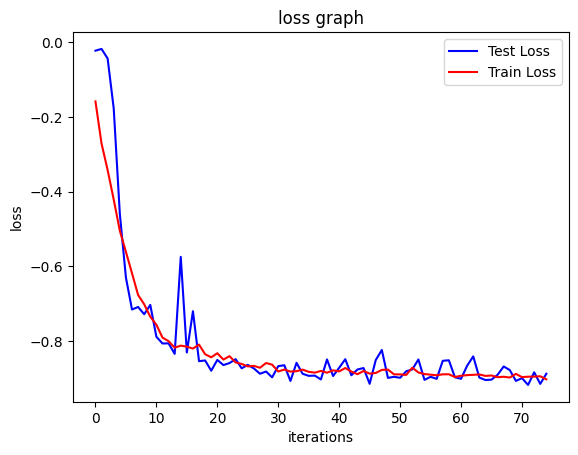

<Figure size 640x480 with 0 Axes>

In [21]:
history_training = history.history

train_dice_coeff_list = history_training['dice_coefficients']
test_dice_coeff_list = history_training['val_dice_coefficients']

train_jaccard_list = history_training['iou']
test_jaccard_list = history_training['val_iou']

train_loss_list = history_training['loss']
test_loss_list = history_training['val_loss']


plt.plot(test_loss_list, 'b-', label='Test Loss')
plt.plot(train_loss_list, 'r-', label='Train Loss')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)
plt.legend()
plt.show()
plt.savefig('Loss Graph')

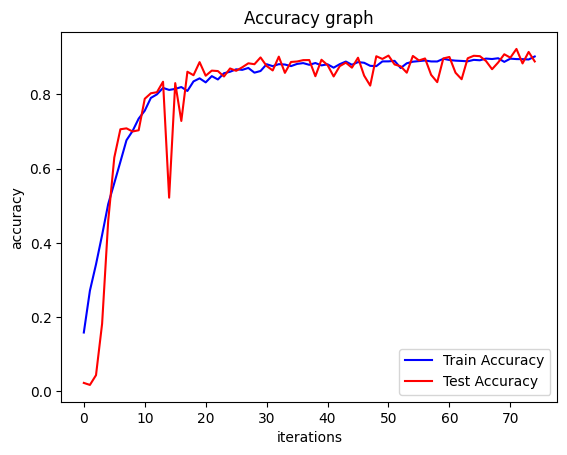

<Figure size 640x480 with 0 Axes>

In [24]:
plt.plot(train_dice_coeff_list, 'b-', label='Train Accuracy')
plt.plot(test_dice_coeff_list, 'r-', label = 'Test Accuracy')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.legend()
plt.show()
plt.savefig('Accuracy Graph')

In [27]:
model = load_model('unet_model.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients})

In [31]:
test_gen = train_generator(df_test, batch_size, dict(), target_size=(img_height,img_width))

results = model.evaluate(test_gen, steps = len(df_test)/batch_size)
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 6s 427ms/step - loss: -0.9029 - binary_accuracy: 0.9981 - iou: 0.8277 - dice_coefficients: 0.9047
Test Loss -0.9028638005256653
Test IOU 0.9980537295341492
Test Dice Coeff 0.8277075886726379


### Model Accuracy

1/1 [==============================] - 0s 22ms/step


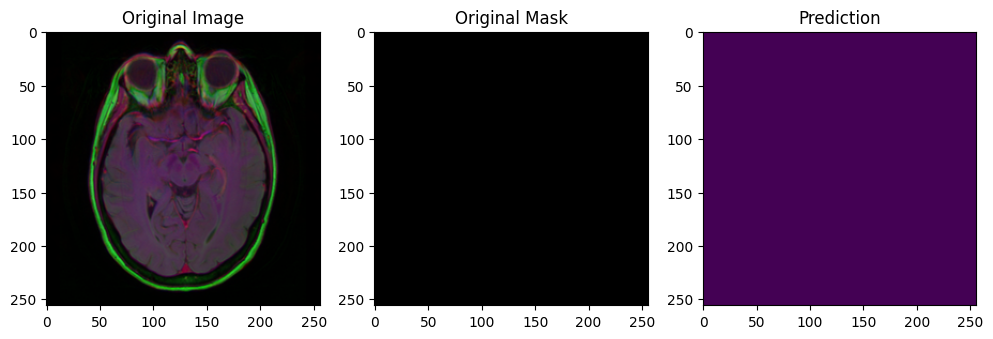

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

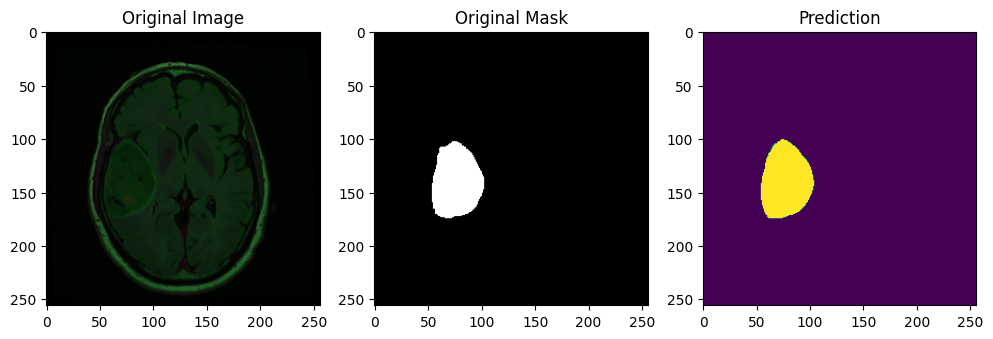

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

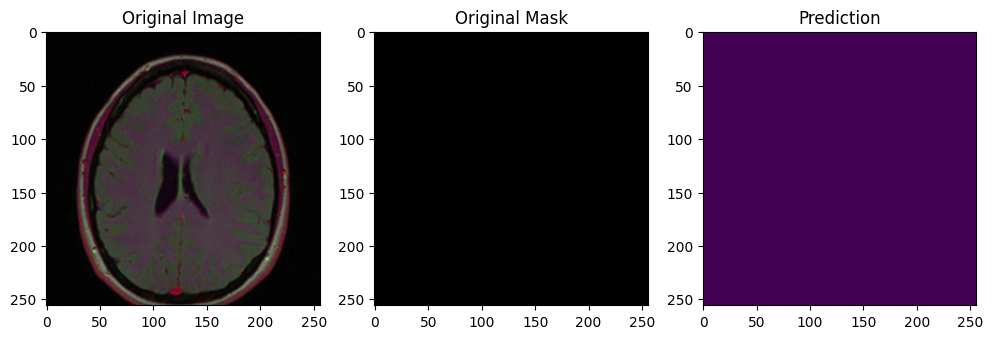

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

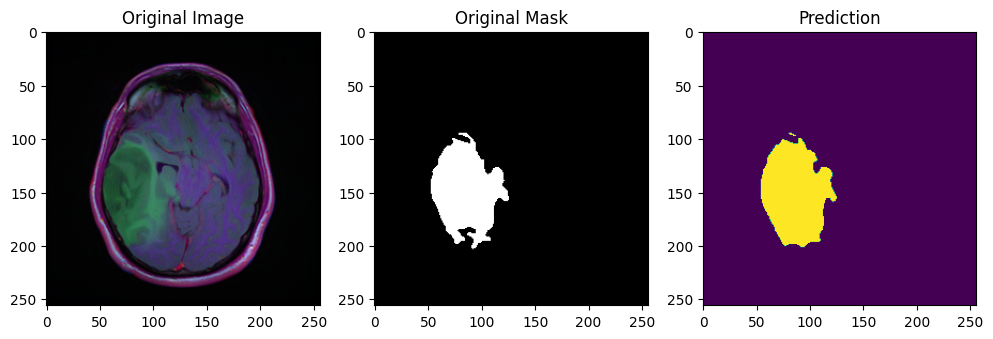

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

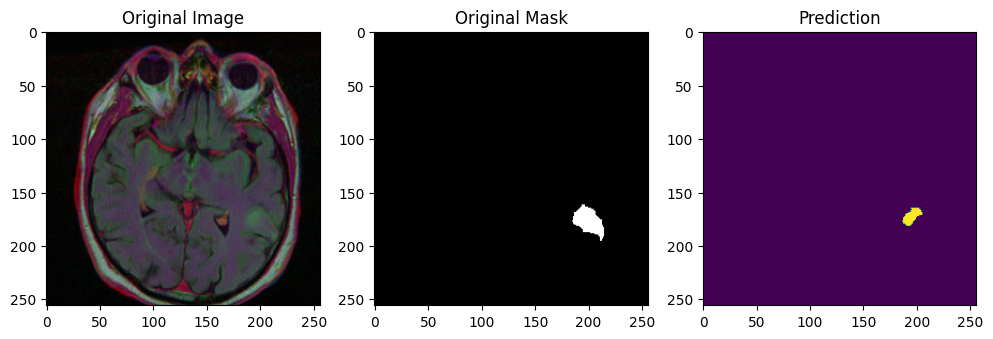

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

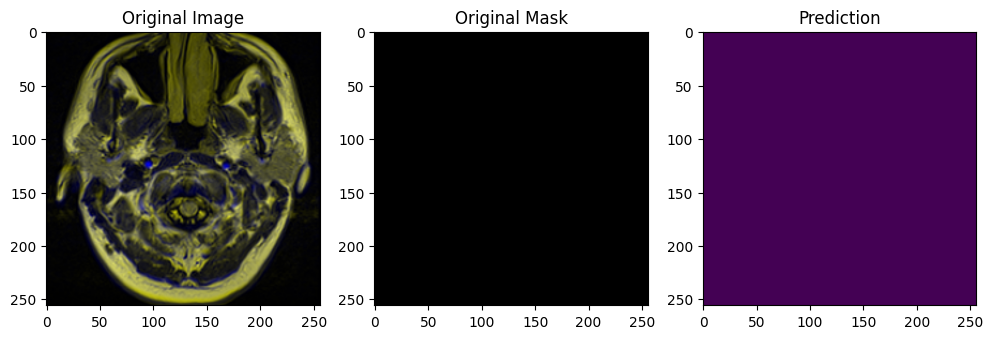

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

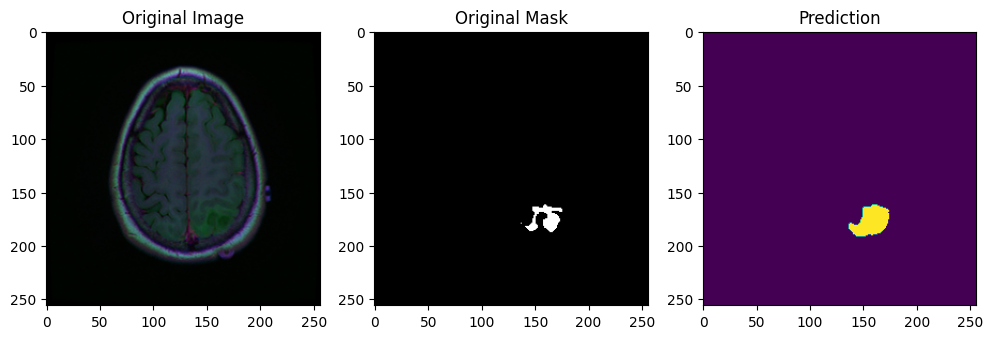

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

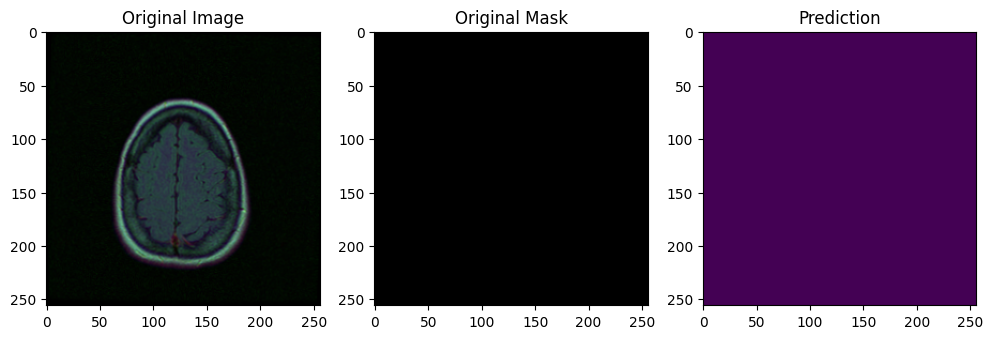

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

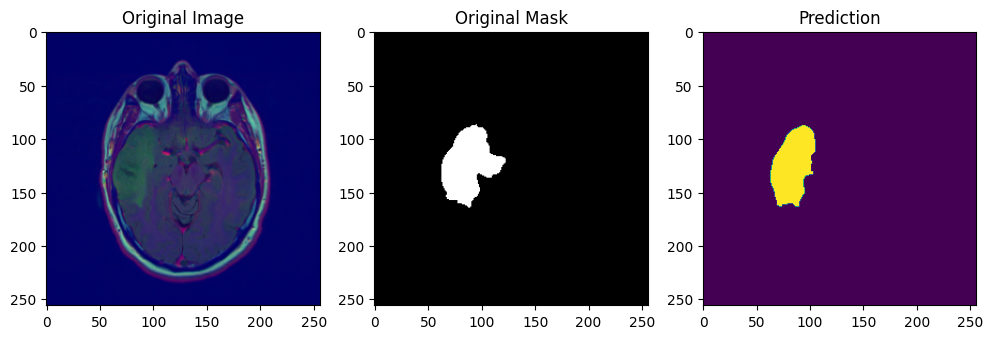

1/1 [==============================] - 0s 20ms/step


<Figure size 640x480 with 0 Axes>

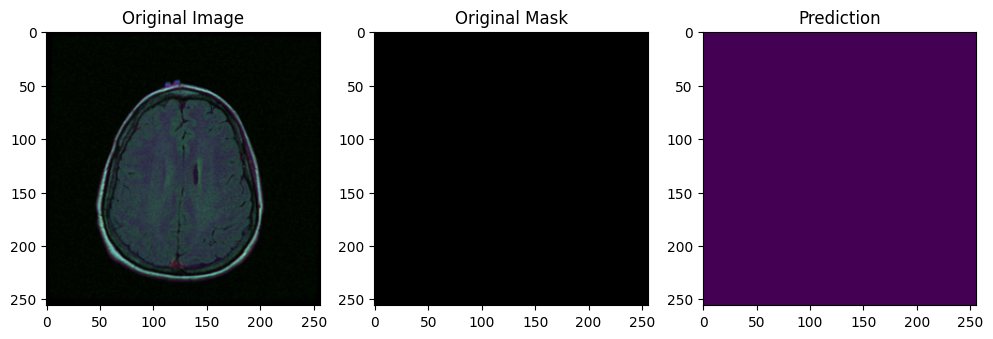

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

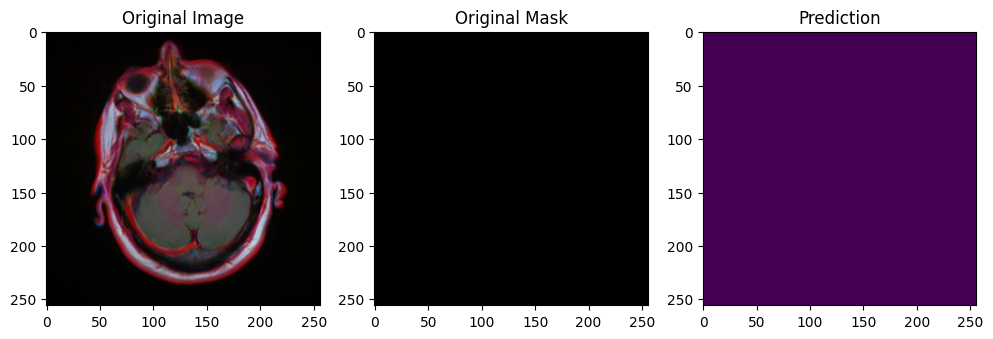

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

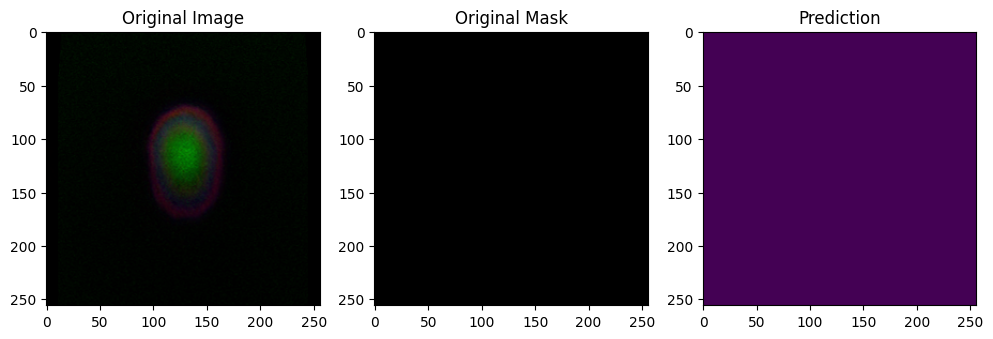

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

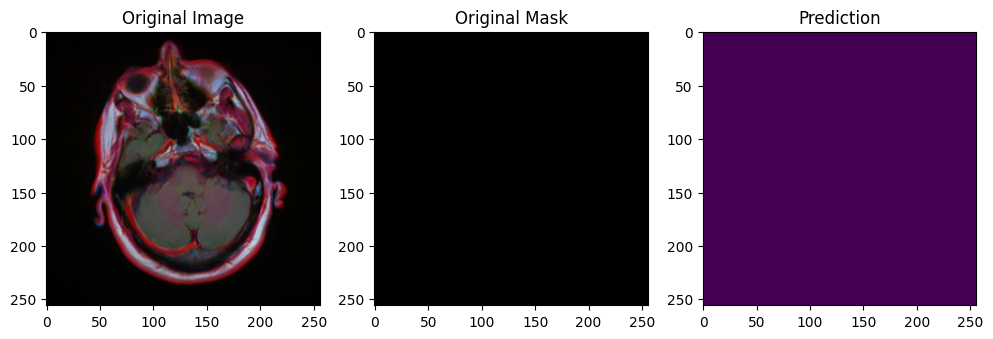

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

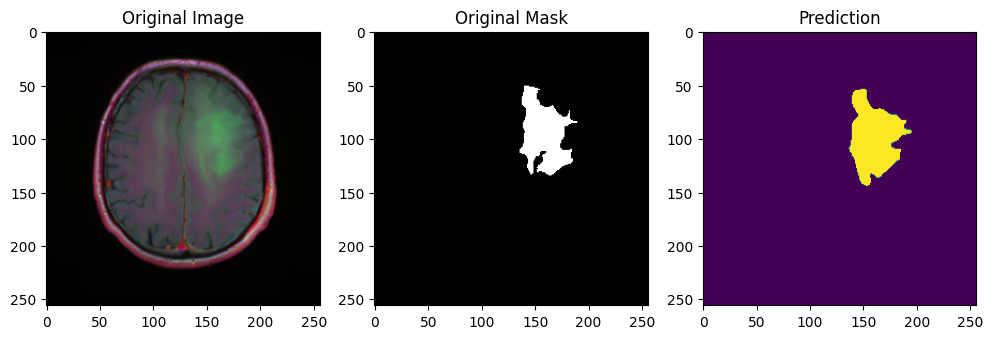

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

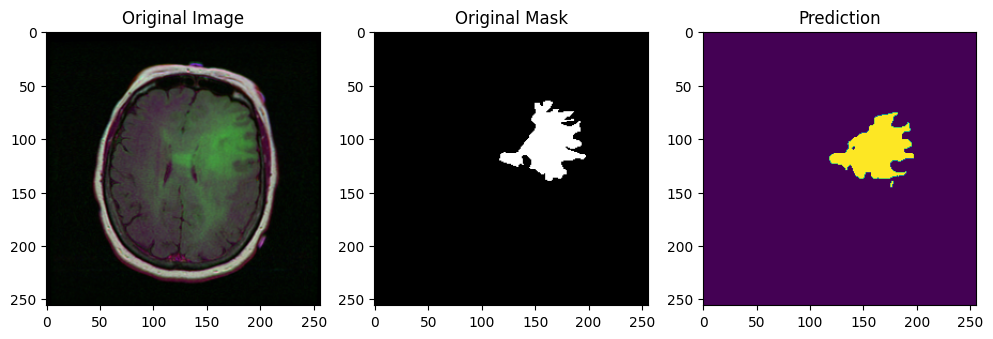

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

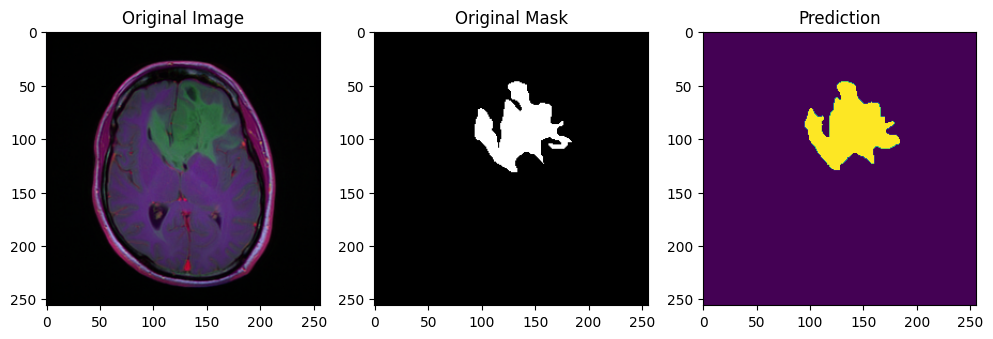

1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

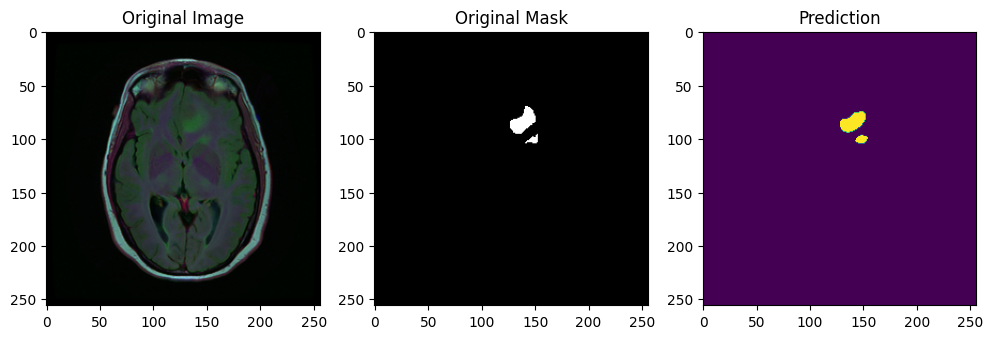

1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

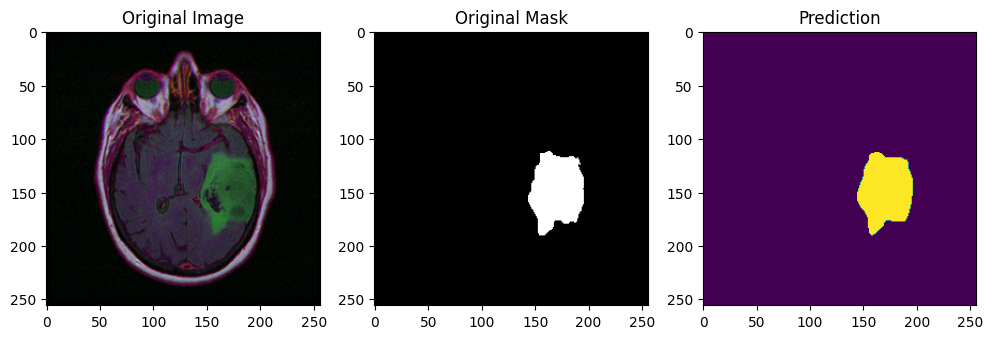

1/1 [==============================] - 0s 20ms/step


<Figure size 640x480 with 0 Axes>

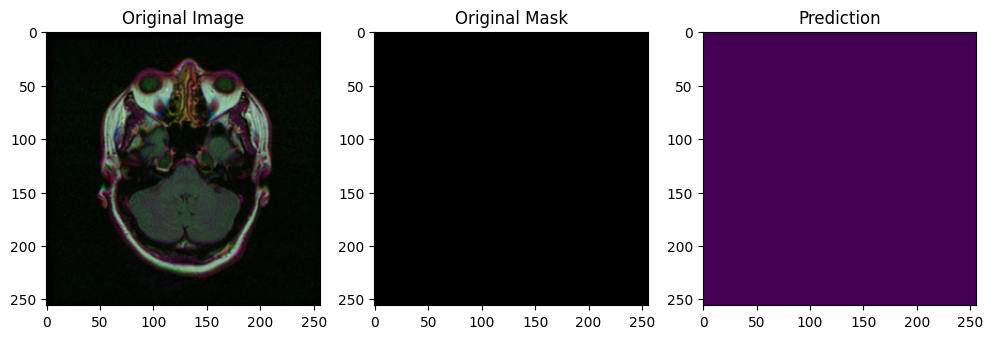

1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

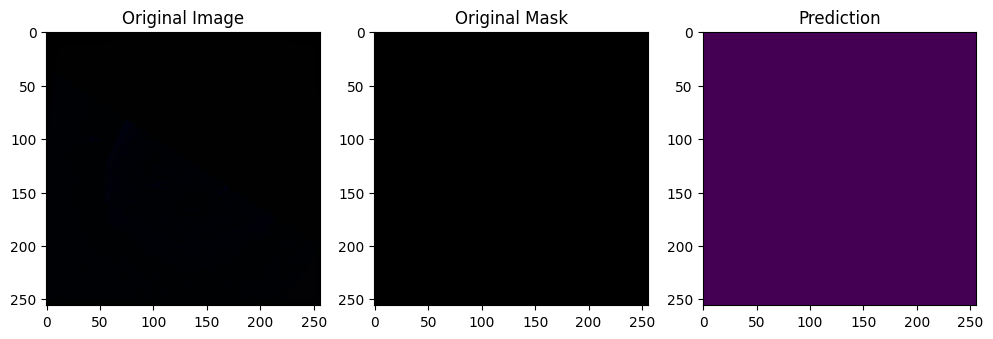

<Figure size 640x480 with 0 Axes>

In [36]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['images_train'].iloc[index])
    img = cv2.resize(img, (img_height,img_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['masks'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5)
    plt.title("Prediction")
    plt.show()
    plt.savefig('Originals vs Predictions')

#### Saving training history for future uses

In [40]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)